In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.rcParams.update({"font.size": 20, "xtick.direction": "in", "ytick.direction": "in"})

C = 299_800_000

In [115]:
def lim(function, target, l0, r0):
    converging = True

    while converging:
        l1, r1 = np.mean([l0, target]), np.mean([r0, target]) # Half the difference between the left/right hand value and the target
        l2, r2 = np.mean([l1, target]), np.mean([r1, target])

        fl0, fr0 = function(l0), function(r0)
        fl1, fr1 = function(l1), function(r2)
        fl2, fr2 = function(l2), function(r2)

        delta_l0, delta_r0 = np.abs(fl1 -fl0), np.abs(fr1 -fr0)
        delta_l1, delta_r1 = np.abs(fl2 -fl1), np.abs(fr2 -fr1)

        if delta_l1 < delta_l0 and delta_r1 < delta_r0: #limit is converging :)
            l0, r0 = l1, r1
        else: #limit is diverging >:(. This is assumed to be a numerical error rather than a mathematical property of the function.
            converging = False

    return np.mean([fl0, fr0]) #Given that the limit converges, it should lie somewhere between the left and right hand limits.

def kramers_kronig(omega, rho):
    assert len(omega) == len(rho), "All values in the function must have a corrisponding frequency."
    N = len(omega)

    sort = np.argsort(omega)
    unsort = np.argsort(sort)
    delta_omega = np.diff(omega[sort], append= 2*omega[sort][-1] -omega[sort][-2]) # Extrapolate the last value.
    delta_omega = delta_omega[unsort] # When approximatating an intergral to the sum of many rectangles, we must find the area by multiplying by the width of the rectangles.

    summation = np.zeros(N)
    integrand = np.zeros(N)

    for x, dx, rho_x, n in zip(omega, delta_omega, rho, np.arange(N)):
        numerator = -omega *np.log(rho_x /rho)
        denominator = omega**2 -x**2
        integrand= numerator/denominator

        ###### SOLVING LIMIT #####
        rho_func = lambda y: np.interp(y, omega, rho)
        integrand_func = lambda y: -x *np.log(rho_func(y)/rho_x) /(x**2 -y**2) # I have used x as the frequency and y as the integral variable. (instead of omega and x)

        integrand[n] = lim(integrand_func, x, x-dx, x+dx)

        summation += integrand *dx

    return 2/np.pi *summation

def recip(x):
    return C*1e-6 / x #converts um to THz or vice versa.

def format_ticks(x, pos):
    return f"{x:.1f}"  # Format the tick label with one decimal place

def gaussian(x, center, FWHM, normalisation_coeffient):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    return normalisation_coeffient *np.exp(exponent)

In [116]:
File = open("plotDataqq.txt", 'rt')
epac_data = np.loadtxt(File, delimiter = " ")
File.close()

ideal_z, ideal_bunch = epac_data.T # Z displacement in um, bunch profile normalised to its peak(?)

ideal_time = ideal_z *1e-6 /C # in s
ideal_sampling_period = np.median(np.diff(ideal_time)) # should be regularly spaced anyway
ideal_N = len(ideal_time)
#ideal_bunch /= np.sum(ideal_bunch) # normalise to its intergral

#ideal_bunch[:100] = 0

In [117]:
padding = 10000 # number of samples to zero padd at the end of the bunch

ideal_time = np.append(ideal_time, ideal_time[-1] +ideal_sampling_period*np.arange(padding))
ideal_bunch = np.append(ideal_bunch, np.zeros(padding))
padded_N = len(ideal_bunch) # = ideal_N +padding

#ideal_time = np.append(ideal_sampling_period*np.arange(padded_N-2) -ideal_time[-1], ideal_time)
#ideal_bunch = np.append(np.zeros(padded_N -2), ideal_bunch)
#padded_N = len(ideal_bunch)

In [118]:
ideal_CFF = np.fft.rfft(ideal_bunch, norm= "forward")
ideal_CFF /= np.max(ideal_CFF) #normalise to peak
ideal_freqs = np.fft.rfftfreq(padded_N, ideal_sampling_period)

ideal_FF = np.abs(ideal_CFF)**2
ideal_FF /= np.max(ideal_FF) #normalise to peak

In [119]:
theta = 30 #arcminutes
sin_minutes = lambda min: np.sin(np.deg2rad(min/60))

### DETECTOR 1 ###
cam1_N = 640 # number of pixels
cam1_dx = 20 # pixel pitch in um
cam1_band = (176.3, 299.8) # sensitivity of camera. (minmimum frequency in THz, maximum frequency in THz)

cam1_dt = (2*sin_minutes(theta)*cam1_dx*1e-6) / C
cam1_time = np.arange(0, cam1_dt*cam1_N, cam1_dt)
cam1_freqs = np.fft.rfftfreq(cam1_N, cam1_dt)
cam1_FF = np.interp(cam1_freqs, ideal_freqs, ideal_FF)
cam1_sensitivity_mask = np.logical_and(cam1_band[0]*1e12 < cam1_freqs, cam1_freqs < cam1_band[1]*1e12)
cam1_FF[~cam1_sensitivity_mask] = 0.0 #camera is insensitive to these frequencies and so it will read zero.

### DETECTOR 2 ###
cam2_N = 320 # number of pixels
cam2_dx = 48.5 # pixel pitch in um
cam2_band = (-1, 176.3) # sensitivity of camera. (minmimum frequency in THz, maximum frequency in THz)

cam2_dt = (2*sin_minutes(theta)*cam2_dx*1e-6) / C # number of pixels x pixel pitch = detector length
cam2_time = np.arange(0, cam2_dt*cam2_N, cam2_dt)
cam2_freqs = np.fft.rfftfreq(cam2_N, cam2_dt)
cam2_FF = np.interp(cam2_freqs, ideal_freqs, ideal_FF)
cam2_sensitivity_mask = np.logical_and(cam2_band[0]*1e12 < cam2_freqs, cam2_freqs < cam2_band[1]*1e12)
cam2_FF[~cam2_sensitivity_mask] = 0.0 #camera is insensitive to these frequencies and so it will read zero.

C:\Users\syf83691\AppData\Local\Temp\ipykernel_10556\2286099187.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


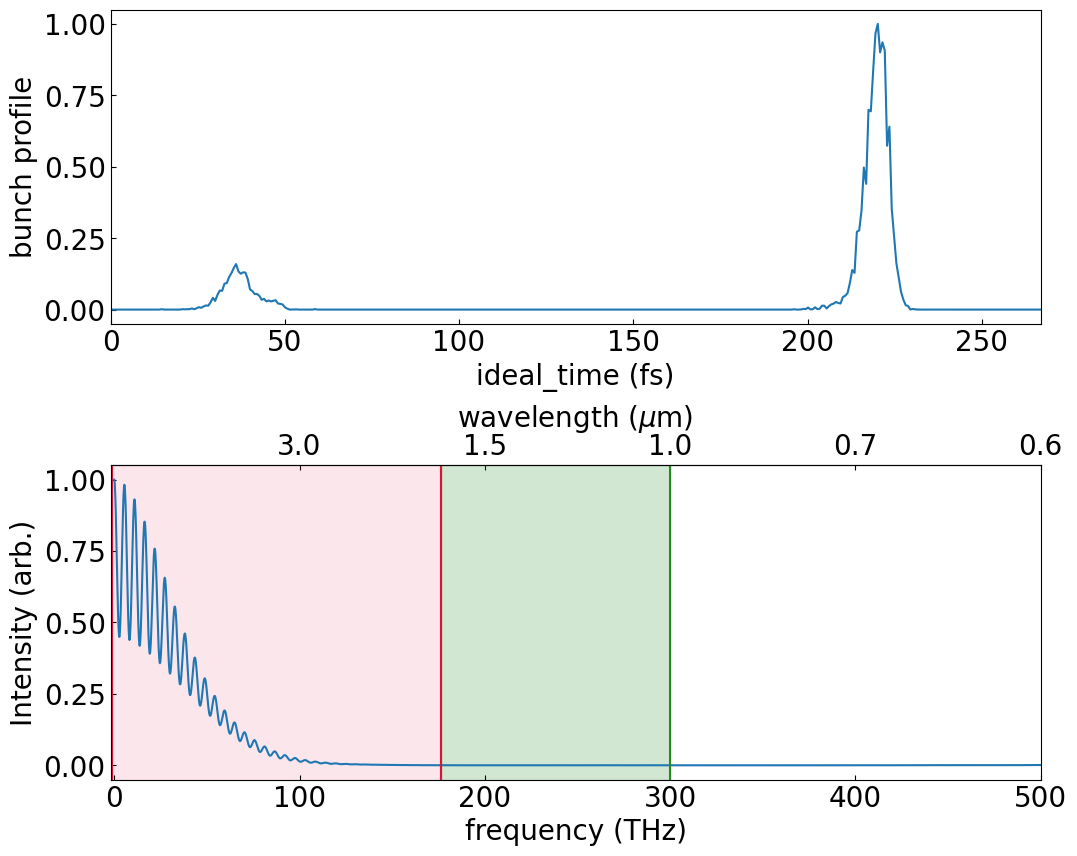

In [120]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.45})

axs[0].plot(ideal_time *1e15, ideal_bunch)
axs[0].set(xlabel= "ideal_time (fs)", ylabel= "bunch profile", xlim= (0, ideal_N*ideal_sampling_period*1e15))


axs[1].plot(ideal_freqs *1e-12, ideal_FF)
axs[1].set(xlabel= "frequency (THz)", ylabel= "Intensity (arb.)", xlim= (-2, 500))

#axs[1].plot(cam1_freqs[1:] *1e-12, cam1_FF[1:], linestyle= "None", marker= ".", color= "forestgreen")
axs[1].fill_betweenx([0,1], 2*[cam1_band[0]], 2*[cam1_band[1]], color= "forestgreen", alpha= 0.2, transform= axs[1].get_xaxis_transform(), label= "Xeva bandwidth")
axs[1].vlines([cam1_band[0], cam1_band[1]], 0, 1, color= "forestgreen", transform= axs[1].get_xaxis_transform())

#axs[1].plot(cam2_freqs[1:] *1e-12, cam2_FF[1:], linestyle= "None", marker= ".", color= "crimson")
axs[1].fill_betweenx([0,1], 2*[cam2_band[0]], 2*[cam2_band[1]], color= "crimson", alpha= 0.1, transform= axs[1].get_xaxis_transform(), label= "PV320 bandwidth")
axs[1].vlines([cam2_band[0], cam2_band[1]], 0, 1, color= "crimson", transform= axs[1].get_xaxis_transform())

secax = axs[1].secondary_xaxis('top', functions=(recip, recip))
secax.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[1].get_xticks()[2:]))
secax.xaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.show()

In [121]:
########## INTERPOLATION AND COMBINING DATA ##################

cam1_df = C / (2*sin_minutes(theta)*cam1_N*cam1_dx*1e-6)
cam2_df = C / (2*sin_minutes(theta)*cam2_N*cam2_dx*1e-6)
cam1_nyquist = C / (4*sin_minutes(theta)*cam1_dx*1e-6)
cam2_nyquist = C / (4*sin_minutes(theta)*cam2_dx*1e-6)

### Parameters for interpolated spectrum

both_df = np.min([cam1_df, cam2_df])
both_nyquist = np.max([cam1_nyquist, cam2_nyquist])
print("To combine the spectra, we will assume that we have a {0:.2f} THz resolution up to the nyquist frequency of {1:.1f} THz.".format(both_df*1e-12, both_nyquist*1e-12))

both_dt = 0.5/both_nyquist
both_length = 1/both_df
both_N = round(both_length/both_dt +1)
both_time = np.arange(0, both_length +both_dt/2, both_dt)

both_freqs = np.arange(0, both_nyquist +both_df/2, both_df)
temp_f = np.concatenate([cam1_freqs[cam1_sensitivity_mask], cam2_freqs[cam2_sensitivity_mask]])
temp_FF = np.concatenate([cam1_FF[cam1_sensitivity_mask], cam2_FF[cam2_sensitivity_mask]])
_, sort = np.unique(temp_f, return_index= True)
both_FF = np.interp(both_freqs, temp_f[sort], temp_FF[sort]) # NP.INTERP WILL ALSO EXTRAPOLATE. It does linear interpolation and nearest neighbor extrapolation.
both_sensitivity_mask = np.logical_or(np.logical_and(cam1_band[0]*1e12 < both_freqs, both_freqs < cam1_band[1]*1e12),
                                      np.logical_and(cam2_band[0]*1e12 < both_freqs, both_freqs < cam2_band[1]*1e12))

To combine the spectra, we will assume that we have a 1.11 THz resolution up to the nyquist frequency of 429.4 THz.


In [122]:
cam1_phase = np.zeros_like(cam1_freqs) #The phase of 0 is undefined. Set it to 0.
cam2_phase = np.zeros_like(cam2_freqs)
both_phase = np.zeros_like(both_freqs)

cam1_phase[cam1_sensitivity_mask] = kramers_kronig(cam1_freqs[cam1_sensitivity_mask], np.sqrt(cam1_FF[cam1_sensitivity_mask])) #retive phase using KK relations
cam2_phase[cam2_sensitivity_mask] = kramers_kronig(cam2_freqs[cam2_sensitivity_mask], np.sqrt(cam2_FF[cam2_sensitivity_mask]))
both_phase[both_sensitivity_mask] = kramers_kronig(both_freqs[both_sensitivity_mask], np.sqrt(both_FF[both_sensitivity_mask]))

############## FUDGE FACTORS FOR AMBIGUITY PROBLEM ############## 
""" There are 3 sources of ambiguity.
TIME SHIFT : Doesn't matter much. Can be resolved if you know (for example) when the peak occours.
REFLECTION : Slightly more problematic. Could be resolved if you know the order of the bunches.
INTERNAL STRUCTURE : Big problem at high resolution with no obvious fix. Numberical methods like the Gerchberg-Saxton algorithm try to find the most probable internal structure.
"""

### REFLECTION
reflected = True
if reflected: cam1_fudged, cam2_fudged, both_fudged = -cam1_phase, -cam2_phase, -both_phase

cam1_CFF = np.sqrt(cam1_FF) *np.exp(1j*cam1_fudged) #apply phase
cam2_CFF = np.sqrt(cam2_FF) *np.exp(1j*cam2_fudged) #apply phase
both_CFF = np.sqrt(both_FF) *np.exp(1j*both_fudged) #apply phase
cam1_bunch = np.fft.irfft(cam1_CFF, norm= "forward", n= cam1_N)
cam2_bunch = np.fft.irfft(cam2_CFF, norm= "forward", n= cam2_N)
both_bunch = np.fft.irfft(both_CFF, norm= "forward", n= both_N)

### TIME SHIFT
ideal_peak = ideal_time[np.argmax(ideal_bunch)]
cam1_peak = cam1_time[np.argmax(cam1_bunch)]
cam2_peak = cam2_time[np.argmax(cam2_bunch)]
both_peak = both_time[np.argmax(both_bunch)]

cam1_fudged -= 2*np.pi*cam1_freqs* (ideal_peak -cam1_peak) # Equivalently, change the phase
cam2_fudged -= 2*np.pi*cam2_freqs* (ideal_peak -cam2_peak) # Equivalently, change the phase
both_fudged -= 2*np.pi*both_freqs* (ideal_peak -both_peak) # Equivalently, change the phase

C:\Users\syf83691\AppData\Local\Temp\ipykernel_10556\2286099187.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


In [123]:
cam1_CFF = np.sqrt(cam1_FF) *np.exp(1j*cam1_fudged) #apply phase
cam2_CFF = np.sqrt(cam2_FF) *np.exp(1j*cam2_fudged) #apply phase
both_CFF = np.sqrt(both_FF) *np.exp(1j*both_fudged) #apply phase

cam1_bunch = np.fft.irfft(cam1_CFF, norm= "forward", n= cam1_N) #inverse fourier transform
cam2_bunch = np.fft.irfft(cam2_CFF, norm= "forward", n= cam2_N)
both_bunch = np.fft.irfft(both_CFF, norm= "forward", n= both_N)

cam1_bunch /= np.max(cam1_bunch) #normalise
cam2_bunch /= np.max(cam2_bunch)
both_bunch /= np.max(both_bunch)

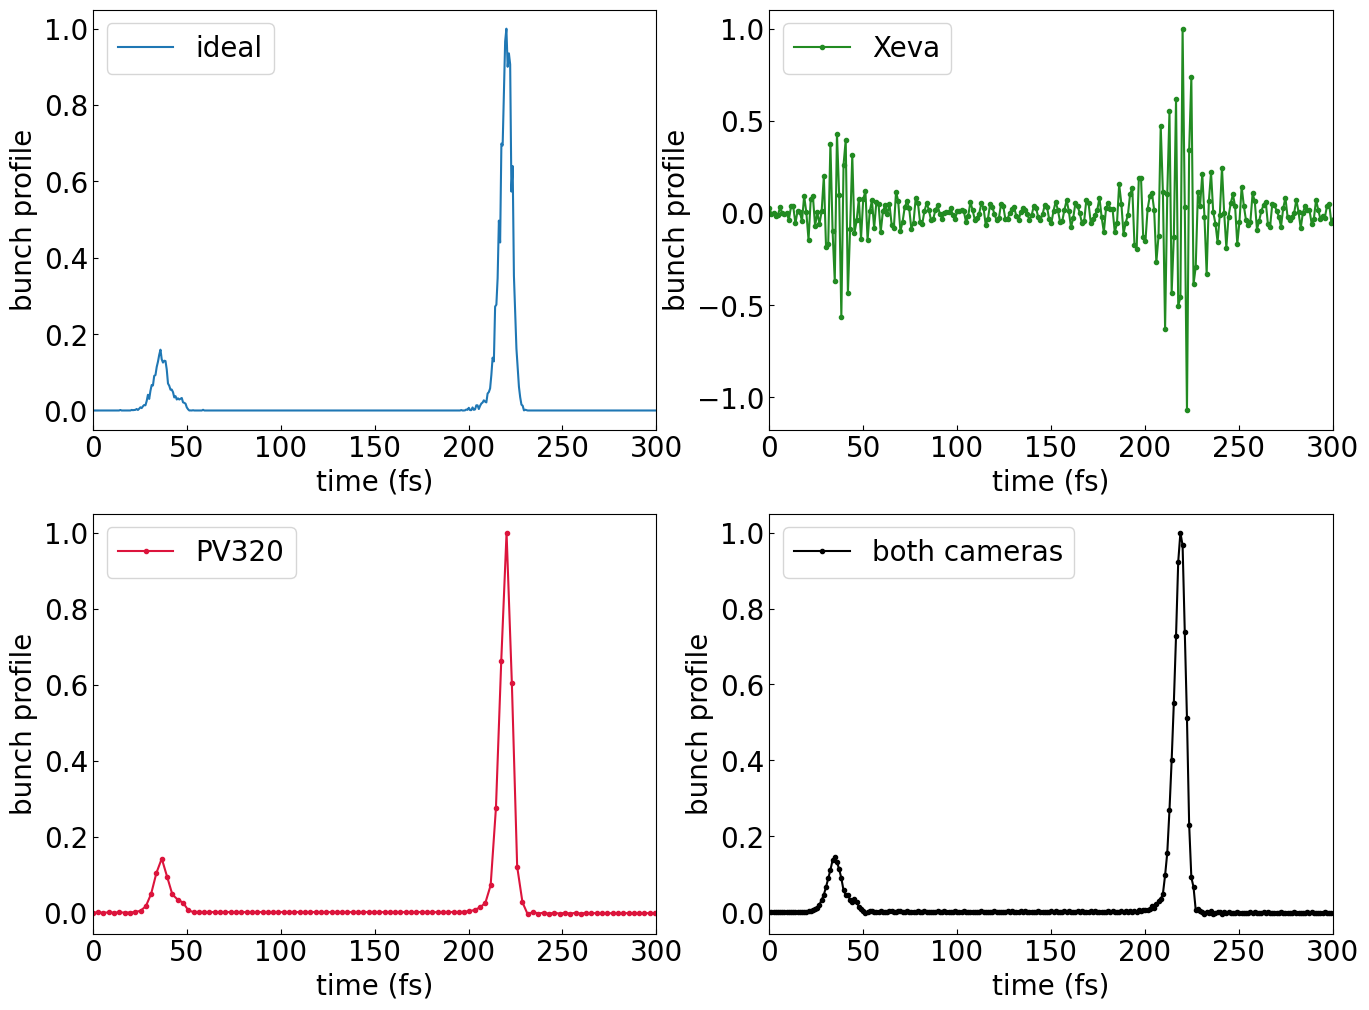

In [124]:
fig, axs = plt.subplots(2, 2, figsize= (16, 12), gridspec_kw= {"hspace": 0.2})
axs = axs.flatten()

axs[0].plot(ideal_time *1e15, ideal_bunch, label= "ideal")
axs[1].plot(cam1_time *1e15, cam1_bunch, marker= ".", label= "Xeva", color= "forestgreen")
axs[2].plot(cam2_time *1e15, cam2_bunch, marker= ".", label= "PV320", color= "crimson")
axs[3].plot(both_time *1e15, both_bunch, marker= ".", label= "both cameras", color= "k")

for ax in axs:
    ax.set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (0, 300))
    ax.legend()

plt.show()

### HERE

C:\Users\syf83691\AppData\Local\Temp\ipykernel_10556\2286099187.py:37: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator
C:\Users\syf83691\AppData\Local\Temp\ipykernel_10556\2286099187.py:50: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa.


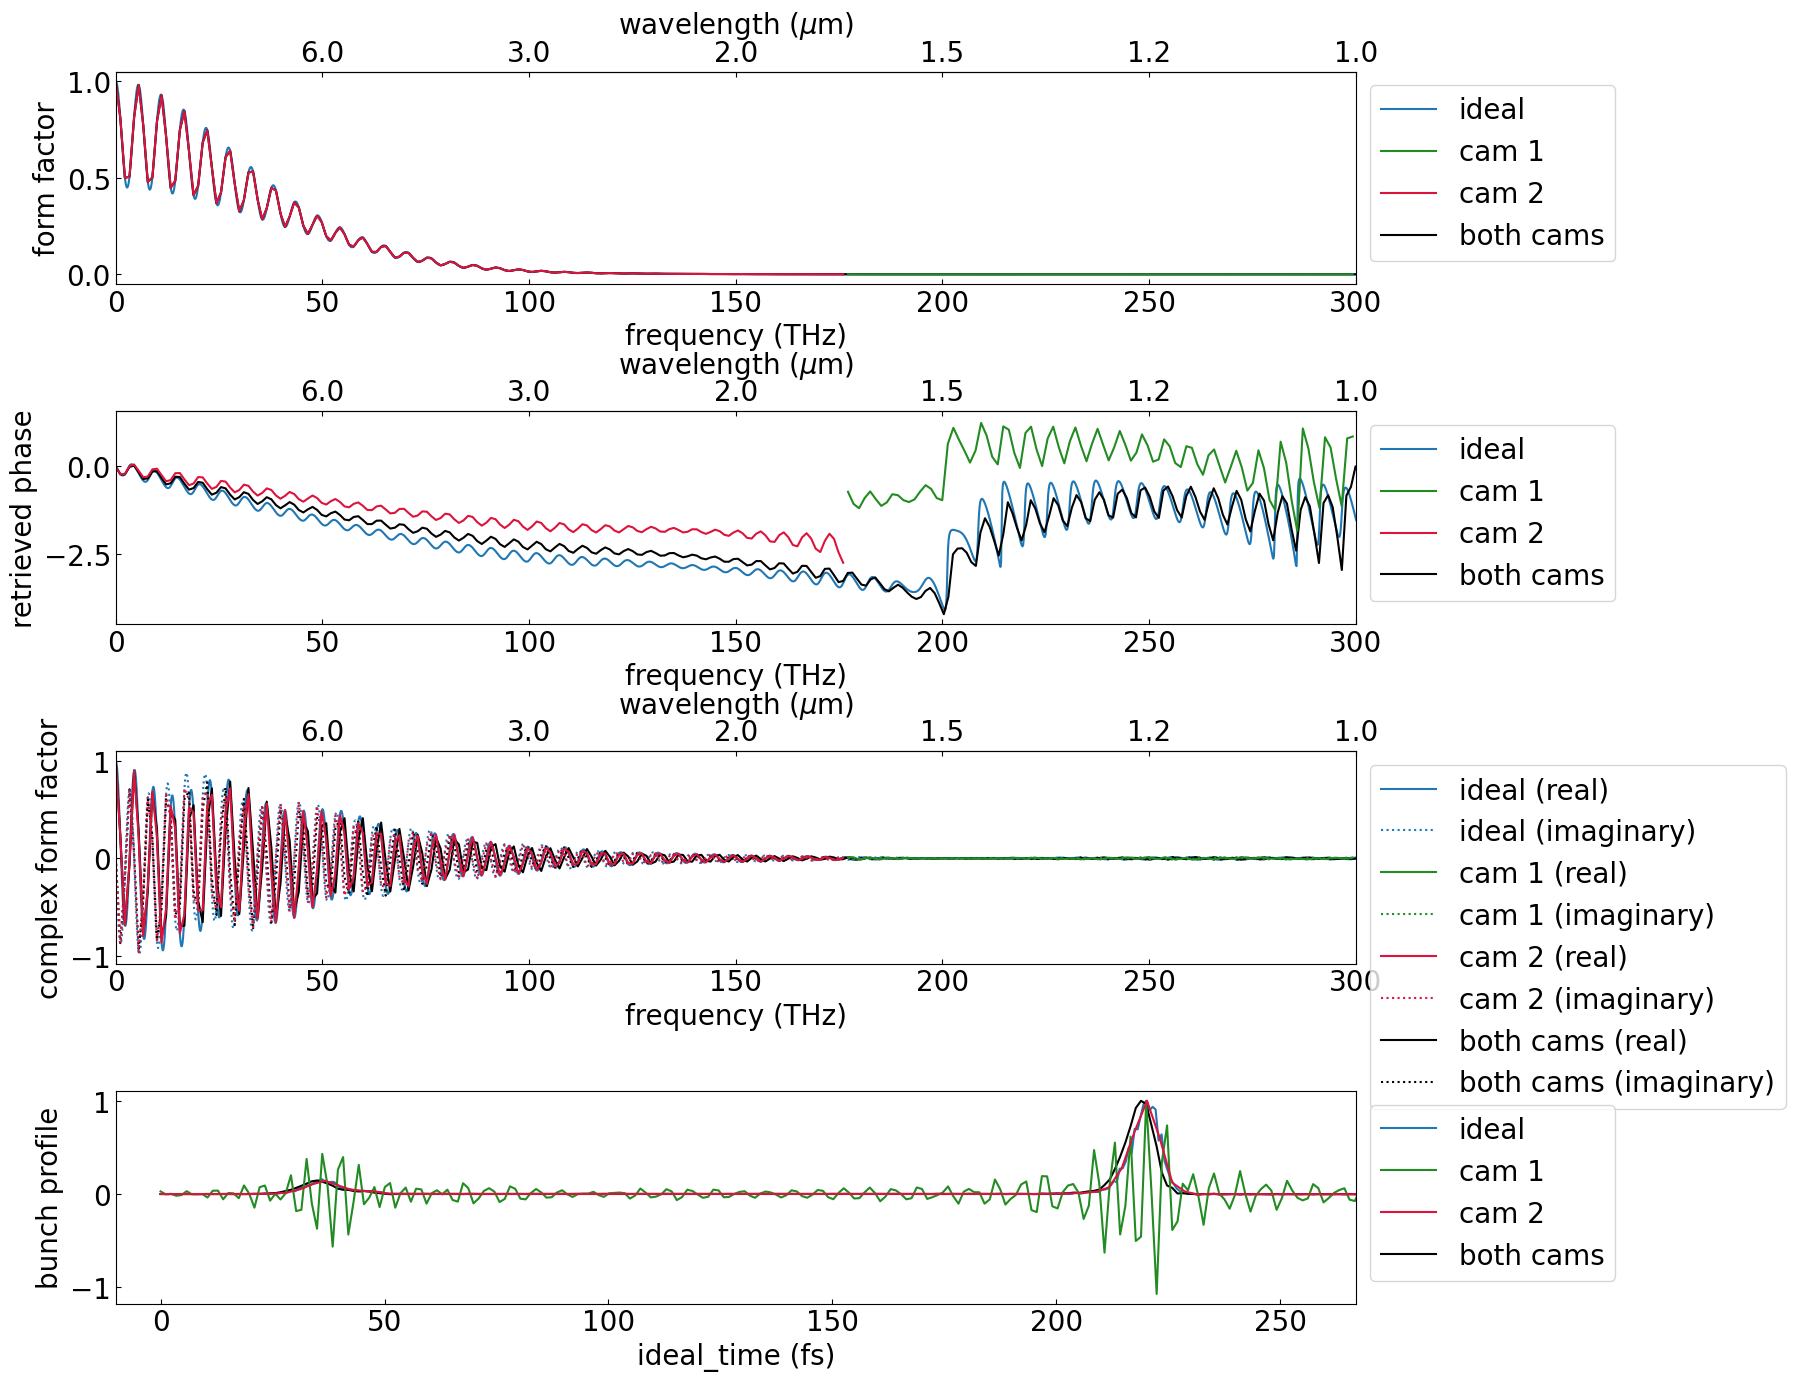

In [125]:
fig, axs = plt.subplots(4, 1, figsize= (16, 16), gridspec_kw= {"hspace": 0.6})

axs[0].plot(ideal_freqs *1e-12, ideal_FF, color= "tab:blue", label= "ideal", zorder= 1.7)
axs[0].plot(cam1_freqs[cam1_sensitivity_mask] *1e-12, cam1_FF[cam1_sensitivity_mask], color= "forestgreen", label= "cam 1", zorder= 1.9)
axs[0].plot(cam2_freqs[cam2_sensitivity_mask] *1e-12, cam2_FF[cam2_sensitivity_mask], color= "crimson", label= "cam 2")
axs[0].plot(both_freqs *1e-12, both_FF, color= "black", label= "both cams", zorder= 1.8)
axs[0].set(xlabel= "frequency (THz)", ylabel= "form factor", xlim= (1e-10, 300))

secax0 = axs[0].secondary_xaxis('top', functions=(recip, recip))
secax0.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[0].get_xticks()[1:]))
secax0.xaxis.set_major_formatter(FuncFormatter(format_ticks))

axs[1].plot(ideal_freqs *1e-12, kramers_kronig(ideal_freqs, np.sqrt(ideal_FF)), color= "tab:blue", label= "ideal", zorder= 1.7)
axs[1].plot(cam1_freqs[cam1_sensitivity_mask] *1e-12, cam1_phase[cam1_sensitivity_mask], color= "forestgreen", label= "cam 1", zorder= 1.9)
axs[1].plot(cam2_freqs[cam2_sensitivity_mask] *1e-12, cam2_phase[cam2_sensitivity_mask], color= "crimson", label= "cam 2")
axs[1].plot(both_freqs*1e-12, both_phase, color= "black", label= "both cams", zorder= 1.8)
axs[1].set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (1e-10, 300))

secax1 = axs[1].secondary_xaxis('top', functions=(recip, recip))
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[1].get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(format_ticks))

axs[2].plot(ideal_freqs *1e-12, ideal_CFF.real, color= "tab:blue", label= "ideal (real)", zorder= 1.7)
axs[2].plot(ideal_freqs *1e-12, ideal_CFF.imag, color= "tab:blue", linestyle= ":", label= "ideal (imaginary)", zorder= 1.7)
axs[2].plot(cam1_freqs[cam1_sensitivity_mask] *1e-12, cam1_CFF[cam1_sensitivity_mask].real, color= "forestgreen", label= "cam 1 (real)", zorder= 1.9)
axs[2].plot(cam1_freqs[cam1_sensitivity_mask] *1e-12, cam1_CFF[cam1_sensitivity_mask].imag, color= "forestgreen", linestyle= ":", label= "cam 1 (imaginary)", zorder= 1.9)
axs[2].plot(cam2_freqs[cam2_sensitivity_mask] *1e-12, cam2_CFF[cam2_sensitivity_mask].real, color= "crimson", label= "cam 2 (real)")
axs[2].plot(cam2_freqs[cam2_sensitivity_mask] *1e-12, cam2_CFF[cam2_sensitivity_mask].imag, color= "crimson", linestyle= ":", label= "cam 2 (imaginary)")
axs[2].plot(both_freqs *1e-12, both_CFF.real, color= "black", label= "both cams (real)", zorder= 1.8)
axs[2].plot(both_freqs *1e-12, both_CFF.imag, color= "black", linestyle= ":", label= "both cams (imaginary)", zorder= 1.8)
axs[2].set(xlabel= "frequency (THz)", ylabel= "complex form factor", xlim= (1e-10, 300))

secax2 = axs[2].secondary_xaxis('top', functions=(recip, recip))
secax2.set(xlabel= "wavelength ($\mu$m)", xticks= recip(axs[2].get_xticks()[1:]))
secax2.xaxis.set_major_formatter(FuncFormatter(format_ticks))

axs[3].plot(ideal_time *1e15, ideal_bunch, color= "tab:blue", label= "ideal", zorder= 1.7)
axs[3].plot(cam1_time *1e15, cam1_bunch, color= "forestgreen", label= "cam 1", zorder= 1.9)
axs[3].plot(cam2_time *1e15, cam2_bunch, color= "crimson", label= "cam 2")
axs[3].plot(both_time *1e15, both_bunch, color= "black", label= "both cams", zorder= 1.8)
axs[3].set(xlabel= "ideal_time (fs)", ylabel= "bunch profile", xlim= (-10, ideal_N*ideal_sampling_period*1e15))

for ax in axs:
    ax.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()